In [9]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib inline
%matplotlib notebook

In [14]:
name = 'house'
#name = 'library'
data_dir = 'data'

# images
I1 = plt.imread(data_dir + '/' + name + '/house1.jpg')
I2 = plt.imread(data_dir + '/' + name + '/house2.jpg')

# K matrices
qq = loadmat(data_dir + '/' + name + '/house1_K.mat')
K1 = qq['K']
print(K1.shape)
qq = loadmat(data_dir + '/' + name + '/house2_K.mat')
K2 = qq['K']

# corresponding points
matches = [x.split('  ')[1:] for x in open(data_dir + '/' + name + '/house_matches.txt').readlines()] 
matches = [[float(y) for y in x] for x in matches]
matches = np.array(matches)

# this is a N x 4 where:
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is the corresponding point in the second image

(3, 3)


In [15]:

plt.imshow(I1)
plt.scatter(matches[:, 0], matches[:, 1], s = 10)
plt.show()
plt.imshow(I2)
plt.scatter(matches[:, 2], matches[:, 3], s = 10)
plt.show()
print("matches shape:", matches.shape)

matches shape: (168, 4)


In [20]:
'''The function that returns the fundamental matrix described in 1.4.1 (Eight Point Algorithm).
This function takes in atleast 8 corresponding points and returns the matrix F and the residual.
'''
def fundamental_matrix(matches):
    #TODO (do this with normalization)

    # normalize
    
    # write mean + std transformations as matrices
    set1 = matches[:, 0:2]
    set2 = matches[:, 2:4]
    
    """mean_fn1, std_fn1 = get_normalize_fns(set1)
    mean_fn2, std_fn2 = get_normalize_fns(set2)"""
    T_1 = get_normalize_mat(set1)
    T_2 = get_normalize_mat(set2)
    set1 = normalize(set1, T_1)
    set2 = normalize(set2, T_2)
    #print(set1)
    A = np.stack(
        [set1[:, 0] * set2[:, 0],
         set1[:, 1] * set2[:, 0],
         set2[:, 0],
         set1[:, 0] * set2[:, 1],
         set1[:, 1] * set2[:, 1],
         set2[:, 1],
         set1[:, 0],
         set1[:, 1],
         np.ones(set1[:, 0].shape)], axis=1)
    U, s, Vh = np.linalg.svd(A)
    F_star = Vh[-1].reshape(3, 3)
    U, s, Vh = np.linalg.svd(F_star)
    s[2] = 0
    return T_2.T @ U @ np.diag(s) @ Vh @ T_1

##Josh Added
'''
This function gets the normalization matrix that can be applied to a data point in HOMOGENOUS
coordinates
'''
def get_normalize_mat(s):
    mu = np.mean(s, axis=0)
    sigma = np.std(np.linalg.norm(s, axis=1))
    return 1/sigma * np.array([[1, 0 ,-mu[0]],
                               [0, 1, -mu[1]],
                               [0, 0,  sigma]])
####

# def normalize(s):
#     return (s - np.mean(s, axis=1).reshape(s.shape[0], 1)) / \
#             np.std(s, axis=1).reshape(s.shape[0], 1)
'''
This normalization method converts to homogenous coordinates to use the tranformation T.
I think this is the correct way
'''
def normalize(s, T):
    ones = np.ones(s.T[0].shape)
    s_prime = np.stack([s.T[0], s.T[1], ones], axis=0)
    return (T @ s_prime).T[:,:2]

def get_normalize_fns(s):
    mean = np.mean(s, axis=0)
    std = np.std(s, axis=0)
    s_homogenous = np.stack([s, np.ones(s.shape[0], 1)], axis=1).T
    
    mean_transformation = np.eye(3)
    mean_transformation[1]
    std_transformation = np.diag(1 / std)

'''Given E, calculates and returns both the rotation and translation between the two cameras.
Described in part 1.4.2. Returning the magnitude of t is impossible, so we return
an array of possible t's and an array of possible R's.
'''
def find_rotation_translation(E):
    U, Sigma, Vh = np.linalg.svd(E)
    S = U
    print(Sigma)
    #the two singular values should be the SAME
    R90_St_R = Vh
    R90t = np.array([[0, -1, 0],
                     [1, 0, 0],
                     [0, 0, 1]])
    R = S @ R90t.T @ R90_St_R
    
    t = S[:, 2]
    return [t, -t], [R, -R]

'''Triangulation function. This takes in the matches, P1, P2, and
finds the best 3D points that reproject to the images in the
two cameras.

This returns a Nx3 matrix of points in 3D space and the 
reconstruction scene. N depends on the number of points
that end up in front of the images planes.'''
def find_3d_points(matches, P1, P2):
    #TODO
#    def get_X_and_err(x1, x2):
#         A = np.array([[(P1[0,0] - x1[0]*P1[2,0]), (P1[0,1] - x1[0]*P1[2,1]), (P1[0,2] - x1[0]*P1[2,2])],
#                       [(P1[1,0] - x1[1]*P1[2,0]), (P1[1,1] - x1[1]*P1[2,1]), (P1[1,2] - x1[1]*P1[2,2])],
#                       [(P2[0,0] - x2[0]*P2[2,0]), (P2[0,1] - x2[0]*P2[2,1]), (P2[0,2] - x2[0]*P2[2,2])],
#                       [(P2[1,0] - x2[1]*P2[2,0]), (P2[1,1] - x2[1]*P2[2,1]), (P2[1,2] - x2[1]*P2[2,2])]])
#         b = np.array([[P1[0, 3] - x1[0]*P1[2, 3]],
#                       [P1[1, 3] - x1[1]*P1[2, 3]],
#                       [P2[0, 3] - x2[0]*P2[2, 3]],
#                       [P2[1, 3] - x2[1]*P2[2, 3]]])
#         X = np.linalg.lstsq(A, b)[0]
#         X_hom = np.append(X, 1)
#         x1_p = P1 @ X_hom
#         x1_p = (x1_p/x1_p[2])[:2]
#         x2_p = P2 @ X_hom
#         x2_p = (x2_p/x2_p[2])[:2]

#         err1 = np.linalg.norm(x1_p - x1)
#         err2 = np.linalg.norm(x2_p - x2)
#         print(x2, x2_p)
        
#         if (X[2] < 0):
#             return None
#         #print(err1, err2)
#         return X, (err1 + err2)/2
    def get_X_and_err(x1, x2):
        A = np.array([[(P1[0,0] - x1[0]*P1[2,0]), (P1[0,1] - x1[0]*P1[2,1]), (P1[0,2] - x1[0]*P1[2,2])],
                      [(P1[1,0] - x1[1]*P1[2,0]), (P1[1,1] - x1[1]*P1[2,1]), (P1[1,2] - x1[1]*P1[2,2])],
                      [(P2[0,0] - x2[0]*P2[2,0]), (P2[0,1] - x2[0]*P2[2,1]), (P2[0,2] - x2[0]*P2[2,2])],
                      [(P2[1,0] - x2[1]*P2[2,0]), (P2[1,1] - x2[1]*P2[2,1]), (P2[1,2] - x2[1]*P2[2,2])]])
        b = np.array([[P1[0, 3] - x1[0]*P1[2, 3]],
                      [P1[1, 3] - x1[1]*P1[2, 3]],
                      [P2[0, 3] - x2[0]*P2[2, 3]],
                      [P2[1, 3] - x2[1]*P2[2, 3]]])
        A = np.concatenate((A, b), axis=1)
        X = np.linalg.svd(A)[2][-1]
        #X = np.linalg.lstsq(A, b)[0]
        X_hom = X
        x1_p = P1 @ X_hom
        x1_p = (x1_p/x1_p[2])[:2]
        x2_p = P2 @ X_hom
        x2_p = (x2_p/x2_p[2])[:2]

        err1 = np.linalg.norm(x1_p - x1)
        err2 = np.linalg.norm(x2_p - x2)
#         print(x1, x1_p)
#         print(x2, x2_p)
        
        if (X[2] < 0):
            return None
        #print(err1, err2)
        return X, (err1 + err2)/2
    
    Xs = []
    errs = []
    set1 = matches[:, 0:2]
    set2 = matches[:, 2:4]
    #set1, set2 = set2, set1
    for i in range(matches.shape[0]):
        x1, x2 = set1[i], set2[i]
        curr = get_X_and_err(x1, x2)
        if curr:
            Xs.append(curr[0].T.flatten())
            errs.append(curr[1])
#     print(np.array(Xs))
    return np.array(Xs), np.average(errs)

[4.05965071e-02 4.04808730e-02 2.40351449e-20]


<IPython.core.display.Javascript object>


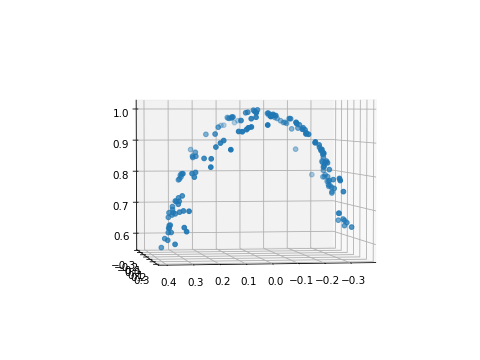

<IPython.core.display.Javascript object>


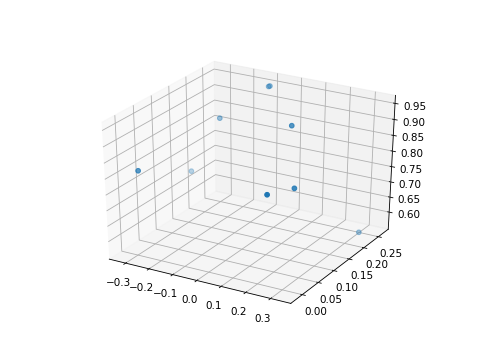

<IPython.core.display.Javascript object>


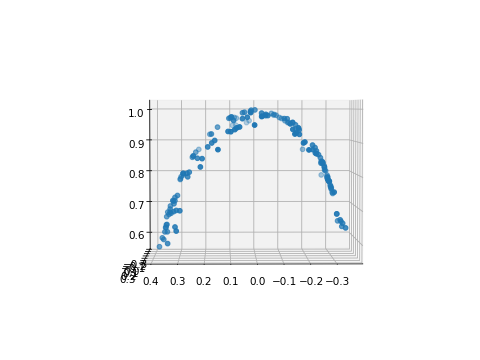

<IPython.core.display.Javascript object>


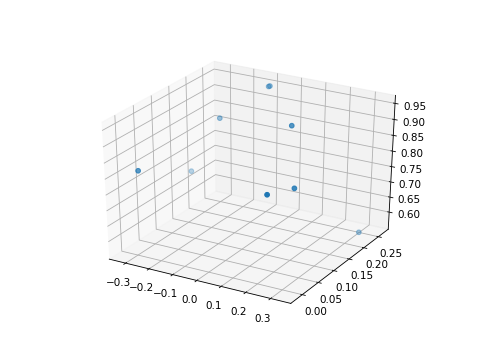

In [21]:
#TODO: visualize matches (maybe)

F = fundamental_matrix(matches)
#print('Residual in f = ', res_err)


#calculate the ESSENTIAL matrix from the FUNDAMENTAL matrix
E = K2.T @ F @ K1

# R : cell array with the possible rotation matrices of second camera
# t : cell array of the possible translation vectors of second camera
t, R = find_rotation_translation(E) 

#P1: P matrix for camera 1
#P2 is calculated on the fly since there are multiple possibilities
P1 = K1 @ np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0]])

# % the number of points in front of the image planes for all combinations
num_points = np.zeros((len(t), len(R)))
# % the reconstruction error for all combinations
errs = np.full((len(t), len(R)), np.inf)

for ti in range(len(t)):
    t2 = t[ti]
    for ri in range(len(R)):
        R2 = R[ri]
        P2 = K2 @ np.column_stack((R2, t2))
        #print(P2)
        points_3d,  errs[ti, ri] = find_3d_points(matches, P1, P2) 
        if len(points_3d) == 0:
            continue
        #print("points_3d", points_3d.shape)
        #print(points_3d)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points_3d[:, 0], points_3d[:, 1], zs=points_3d[:, 2])
        num_points[ti, ri] = points_3d.shape[0]
#print(errs)